A Fully-Convolutional Network using VGG weights for the encoder portion trained on the CityScape dataset to distinguish pixels into the following categories: road, sidewalk, pedestrian, vehicle (including bicycles), background.

# Import and Setup

In [1]:
import tensorflow as tf
import os
import numpy as np
from scipy import misc
import sys
from random import shuffle
from random import uniform
import zipfile
from collections import OrderedDict
import glob
import time
from PIL import Image
from moviepy.editor import VideoFileClip
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Import data
gt_train_path = 'city_fine_gt/train'
imgs_train_path = 'city_fine/train'
gt_val_path = 'city_fine_gt/val'
imgs_val_path = 'city_fine/val'
gt_test_path = 'city_fine_gt/test'
imgs_test_path = 'city_fine/test'
# Get training data filenames
def get_files(imgs_dir, gt_dir):
    
    cities = os.listdir(imgs_dir)
    gt = []
    imgs = []
    for city in cities:
        new_gt_path = os.path.join(gt_dir, city)
        new_imgs_path = os.path.join(imgs_dir, city)
        gt += glob.glob(os.path.join(new_gt_path, "*labelIds.png"))
        imgs += glob.glob(os.path.join(new_imgs_path, "*.png"))
    imgs.sort()
    gt.sort()
    return imgs, gt

train_imgs, train_gt = get_files(imgs_train_path, gt_train_path)
val_imgs, val_gt = get_files(imgs_val_path, gt_val_path)
test_imgs, test_gt = get_files(imgs_test_path, gt_test_path)

In [3]:
# random image for unit tests
random_im_path = 'city_fine/train/jena/jena_000118_000019_leftImg8bit.png'
random_gt_path = 'city_fine_gt/train/jena/jena_000118_000019_gtFine_color.png'
random_instance_path = 'city_fine_gt/train/jena/jena_000118_000019_gtFine_instanceIds.png'
random_label_path = 'city_fine_gt/train/jena/jena_000118_000019_gtFine_labelIds.png'

In [4]:
# downloaded into current directory from ftp://mi.eng.cam.ac.uk/pub/mttt2/models/vgg16.npy
vgg_path = 'vgg16.npy'
# From the VGG paper
vgg_means = [103.939, 116.779, 123.68]

# Utility Functions

In [5]:
def plot_image(image_path=None, img=None, from_path=True):
    if (from_path == True):
        img = misc.imread(image_path)
    if len(img.shape) == 4:
        img = np.squeeze(img)
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    plt.imshow(img)
    plt.show()

In [6]:
# prepare_ground_truth for cityscape data
def prepare_ground_truth(img):
    NUM_CLASSES = 5
    new_image = np.zeros((img.shape[0], img.shape[1], NUM_CLASSES))
    
    # road
    road_mask = img == 7
    # sidewalk
    side_mask = img == 8
    # pedestrians[person,rider,bicycle]
    ped_mask = np.logical_or(img == 24, img == 25)
    # vehicles[car,truck,bus,caravan,trailer,train,motorcycle,license plate]
    car_mask = np.logical_or.reduce((img == 26, img == 27, img == 28,
                                      img == 29, img == 30, img == 31,
                                      img == 32, img == 33, img == -1))
    # everything else
    else_mask = np.logical_not(np.logical_or.reduce((road_mask, side_mask,
                                                     ped_mask, car_mask)))
    
    new_image[:,:,0] = road_mask
    new_image[:,:,1] = side_mask
    new_image[:,:,2] = ped_mask
    new_image[:,:,3] = car_mask
    new_image[:,:,4] = else_mask
    
    return new_image.astype(np.float32)

In [7]:
def get_data(batch_size=1, num_classes=5, mode='train', imgs=train_imgs, gt=train_gt, im_size=500):
    
    # Expects sorted lists of training images and ground truth as
    # 'data' and 'labels'
    if (mode == 'val'):
        imgs = val_imgs
        gt = val_gt
    elif (mode == 'test'):
        imgs = test_imgs
        gt = test_gt
    
    # get shape from any image
    shape_im = misc.imread(random_im_path)
    
    # Shuffle dataset
    combined = list(zip(imgs, gt))
    shuffle(combined)
    imgs[:], gt[:] = zip(*combined)
    
    while(True):
        for i in range(0,len(imgs),batch_size):
            images = np.empty((batch_size, im_size, im_size, shape_im.shape[2]))
            labels = np.empty((batch_size, im_size, im_size, num_classes))
            for j, img in enumerate(imgs[i:i+batch_size]):
                # Crop the size we want from a random spot in the image (as a form of
                # minor data augmentation)
                new_start_row = np.random.randint(0, shape_im.shape[0] - im_size)
                new_start_col = np.random.randint(0, shape_im.shape[1] - im_size)
                train_im = misc.imread(img).astype(np.float32)
                
                train_im = train_im[new_start_row:new_start_row+im_size, new_start_col:new_start_col+im_size]
                images[j,:,:,:] = train_im
                
                gt_im = misc.imread(gt[i+j])
                gt_im = gt_im[new_start_row:new_start_row+im_size, new_start_col:new_start_col+im_size]
                labels[j,:,:,:] = prepare_ground_truth(gt_im)
            
            yield(images,labels)
            

In [8]:
# visualize_prediction for cityscape data
def visualize_prediction(original_image, prediction):
    
    original_image = np.squeeze(original_image).astype(np.uint8)
    new_image = np.copy(original_image)
    prediction = np.squeeze(prediction)
    mask = np.argmax(prediction, axis=2)
    # road = green
    new_image[mask[:,:]==0, :] = [0,255,0]
    # sidewalk = blue
    new_image[mask[:,:]==1, :] = [0,0,255]
    # pedestrians = yellow
    new_image[mask[:,:]==2, :] = [255,255,0]
    # vehicles = red
    new_image[mask[:,:]==3, :] = [255,0,0]
    # else is left the same
    
    new_image = Image.blend(Image.fromarray(original_image, mode='RGB').convert('RGBA'),
                            Image.fromarray(new_image, mode='RGB').convert('RGBA'),
                            alpha=0.5)
    
    plt.imshow(new_image, interpolation='nearest')
    plt.show()

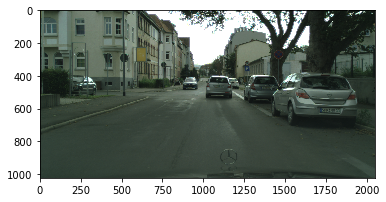

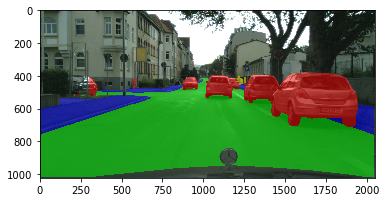

In [9]:
# Check the visualization with ground truth
rand_gt = misc.imread(random_label_path)
rand_im = misc.imread(random_im_path)
plot_image(img=rand_im, from_path=False)
prepped = prepare_ground_truth(rand_gt)
visualize_prediction(rand_im, prepped)

# Model-Building Functions

In [10]:
def vgg_conv(layer_input, vgg_dict, bn, name):
    
    with tf.variable_scope(name):
        
        # Get the conv filter
        init = tf.constant_initializer(value=vgg_dict[name][0], dtype=tf.float32)
        shape = vgg_dict[name][0].shape
        filt = tf.get_variable(name="filter", initializer=init, shape=shape)
        # Get the conv bias
        init = tf.constant_initializer(value=vgg_dict[name][1], dtype=tf.float32)
        shape = vgg_dict[name][1].shape
        bias = tf.get_variable(name="biases", initializer=init, shape=shape)
        # Construct conv layer
        conv = tf.nn.conv2d(layer_input, filt, [1, 1, 1, 1], padding='SAME')
        relu = tf.nn.relu(tf.nn.bias_add(conv, bias), name=name)
        return tf.contrib.layers.batch_norm(relu, center=True, scale=True, is_training=True)

In [11]:
# Helper function for deconvolutional layers
# Note that this function is different than the Unet deconv functions
def deconv2d(layer_input, output_shape, input_fsize, output_fsize, filter_size, stride, bn, name):
    w = tf.get_variable("filter_" + name, shape=[filter_size, filter_size, output_fsize, input_fsize], 
                        initializer=tf.contrib.layers.xavier_initializer_conv2d(), 
                        regularizer=tf.contrib.layers.l2_regularizer(.001))
    b = tf.Variable(tf.constant(0.1, shape=[output_fsize]))
    new_shape = tf.stack([output_shape[0], output_shape[1], output_shape[2], output_fsize])
    deconv = tf.nn.conv2d_transpose(layer_input, w, new_shape, strides=[1, stride, stride, 1], padding='SAME')
    layer = tf.nn.elu(tf.add(deconv, b))
    return tf.contrib.layers.batch_norm(layer, center=True, scale=True, is_training=True)


In [12]:
def conv_layer(layer_input, input_fsize, output_fsize, filter_size, bn, name):
    w = tf.get_variable("filter_" + name, shape=[filter_size, filter_size, input_fsize, output_fsize], 
                        initializer=tf.contrib.layers.xavier_initializer_conv2d(), 
                        regularizer=tf.contrib.layers.l2_regularizer(.001))
    b = tf.Variable(tf.constant(0.1, shape=[output_fsize]))
    layer = tf.nn.elu(tf.add(tf.nn.conv2d(layer_input, w, strides=[1, 1, 1, 1], padding='SAME'), b))
    return tf.contrib.layers.batch_norm(layer, center=True, scale=True, is_training=True)


# Construct Model

In [13]:
def create_FCN_VGG(imgs, vgg_dict, dropout=0.5, channels=3, num_classes=5, filter_size=1, bn=True):
    
    im_rows = tf.shape(imgs)[1]
    im_cols = tf.shape(imgs)[2]
    
    x_image = tf.reshape(imgs, tf.stack([-1,im_rows,im_cols,channels]))
    layer_input = x_image
    batch_size = tf.shape(x_image)[0]
    
    # VGG pre-processing
    red, green, blue = tf.split(x_image, 3, 3)

    x_image = tf.concat([
        blue - vgg_means[0],
        green - vgg_means[1],
        red - vgg_means[2]], axis=3)
    
    x_image = x_image / 122.5
    
    # Encoder
    conv1_1 = vgg_conv(x_image, vgg_dict, bn, "conv1_1")
    conv1_2 = vgg_conv(conv1_1, vgg_dict, bn, "conv1_2")
    pool1 = tf.nn.max_pool(conv1_2, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool1")
    conv2_1 = vgg_conv(pool1, vgg_dict, bn, "conv2_1")
    conv2_2 = vgg_conv(conv2_1, vgg_dict, bn, "conv2_2")
    pool2 = tf.nn.max_pool(conv2_2, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool2")
    conv3_1 = vgg_conv(pool2, vgg_dict, bn, "conv3_1")
    conv3_2 = vgg_conv(conv3_1, vgg_dict, bn, "conv3_2")
    conv3_3 = vgg_conv(conv3_2, vgg_dict, bn, "conv3_3")
    pool3 = tf.nn.max_pool(conv3_3, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool3")
    conv4_1 = vgg_conv(pool3, vgg_dict, bn, "conv4_1")
    conv4_2 = vgg_conv(conv4_1, vgg_dict, bn, "conv4_2")
    conv4_3 = vgg_conv(conv4_2, vgg_dict, bn, "conv4_3")
    pool4 = tf.nn.max_pool(conv4_3, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool4")
    conv5_1 = vgg_conv(pool4, vgg_dict, bn, "conv5_1")
    conv5_2 = vgg_conv(conv5_1, vgg_dict, bn, "conv5_2")
    conv5_3 = vgg_conv(conv5_2, vgg_dict, bn, "conv5_3")
    pool5 = tf.nn.max_pool(conv5_3, ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME', name="pool5")

    # VGG depth at the fifth layer (comes from imported weights so
    # it will be constant no matter the size of input image)
    features = 512
        
    # Decoder
    # Combo layer 1
    d_conv1 = conv_layer(pool5, features, num_classes, filter_size, bn, "decoder_c1")
    d_dconv1 = deconv2d(d_conv1, tf.shape(pool4), num_classes, num_classes, 4, 2, bn, "decoder_d1")
    
    d_conv2 = conv_layer(pool4, features, num_classes, filter_size, bn, "decoder_c2")
    
    # Skip connection
    d_sum1 = tf.add(d_dconv1, d_conv2)
    
    # Combo layer 2
    d_dconv2 = deconv2d(d_sum1, tf.shape(pool3), num_classes, num_classes, 4, 2, bn, "decoder_d2")
    
    d_conv3 = conv_layer(pool3, features//2, num_classes, filter_size, bn, "decoder_c3")
    
    # Skip connection
    d_sum2 = tf.add(d_dconv2, d_conv3)
    
    # Combo layer 3
    d_dconv3 = deconv2d(d_sum2, tf.shape(x_image), num_classes, num_classes, 16, 8, bn, "decoder_d3")

    output = d_dconv3
        
    return output


In [14]:
class FCN_VGG:
    
    def __init__(self, channels=3, num_classes=5, output_path='model'):
        
        # prediction path is to store validation prediction images in if necessary
        self.prediction_path = "predictions"
        self.output_path = output_path
        
        if not os.path.exists(self.prediction_path):
            os.mkdir(self.prediction_path)
        if not os.path.exists(self.output_path):
            os.mkdir(self.output_path)
                
        tf.reset_default_graph()
        
        self.num_classes = num_classes
        
        self.vgg_dict = np.load(vgg_path, encoding='latin1').item()
        
        self.x = tf.placeholder("float", shape=[None, None, None, channels], name="x")
        self.y = tf.placeholder("float", shape=[None, None, None, num_classes], name="y")
        self.drop_pl = tf.placeholder("float", name="do")
        self.bn = tf.placeholder("bool", name="bn")

        logits = create_FCN_VGG(self.x, self.vgg_dict, dropout=self.drop_pl, channels=channels, num_classes=num_classes)
        self.logits = logits
        self.soft = self.pixel_wise_softmax(logits)
        self.soft = tf.identity(self.soft, name="output")
        self.loss = self.get_loss(logits)
                
        # These two are for validation
        self.correct_pred = tf.equal(tf.argmax(tf.squeeze(self.soft), -1), tf.argmax(tf.squeeze(self.y), -1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
            
    # A helper function for computing softmax across the channel-dimension
    def pixel_wise_softmax(self, output):
                
        # Softmax across the last dimension (where each channel is a binary image
        # denoting whether the pixel belongs in that category or not -- this allows
        # for more than two classes)
        # e^x
        exponential_map = tf.exp(output)
        # sum-e^x
        sum_exp = tf.reduce_sum(exponential_map, 3, keep_dims=True)
        # duplicate the last summed dimension
        tensor_sum_exp = tf.tile(sum_exp, tf.stack([1, 1, 1, tf.shape(output)[3]]))
        # divide e^x by sum-e^x 
        return tf.div(exponential_map, tensor_sum_exp)
        
    def get_loss(self, logits):

        cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=self.y, logits=logits))
        
        reg_loss = sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
        
        cost += reg_loss
        
        return cost

    
    def predict(self, model_path, img, gt=None, restore=True):
    
        init = tf.global_variables_initializer()
        with tf.Session() as sess:
            
            sess.run(init)
            
            if restore:
                self.restore(sess, os.path.join(self.output_path, model_path))
            
            if gt != None:
                soft, acc = sess.run([self.soft, self.accuracy], feed_dict={self.x: img, self.y: gt,
                                                                            self.drop_pl: 1.0, self.bn: False})
                return soft, acc
            else:
                soft = sess.run(self.soft, feed_dict={self.x: img, self.drop_pl: 1.0, self.bn: False})
                return soft
    
    def save(self, sess, model_path):
        
        saver = tf.train.Saver()
        save_path = saver.save(sess, model_path)
        return save_path
    
    def restore(self, sess, model_path):
        
        saver = tf.train.Saver()
        saver.restore(sess, model_path)
    
    def train(self, data_generator, dropout=0.5, training_iters=10, learning_rate=0.0001, epochs=10, display_step=10, restore=False, model_path=None):
        
        model_path = os.path.join(self.output_path, model_path)
                
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)
        
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            
            print("Session begun")
            
            sess.run(init)
        
            if restore:
                self.restore(sess, model_path)

            for epoch in range(epochs):
                
                print("Starting new epoch")
                
                total_loss = 0.0
                display_loss = 0.0
                display_acc = 0.0
                best_acc = .93
                for step in range((epoch*training_iters), ((epoch+1)*training_iters)):
                    
                    x_batch, y_batch = next(data_generator)
                    
                    _, loss, acc, logits = sess.run((self.optimizer, self.loss, self.accuracy, self.logits),
                                                    feed_dict={self.x: x_batch,
                                                              self.y: y_batch,
                                                              self.drop_pl: dropout,
                                                              self.bn: True})
                    
                    display_loss += loss
                    display_acc += acc
                    
                    if ((step+1) % display_step == 0):
                        print("At iteration {} loss equals {} and accuracy equals {}".format(step+1, display_loss/(display_step), display_acc/(display_step)))
                        
                        if ((display_acc/(display_step)) > best_acc):
                            save_path = self.save(sess, os.path.join(self.output_path, model_path))
                            best_acc = display_acc/display_step
                            print("model saved")
                        total_loss += display_loss
                        display_loss = 0.0
                        display_acc = 0.0
                        
                                                                    
                print("###############################")
                print("Epoch", epoch + 1, "average loss =", total_loss/training_iters)
                print("###############################")
                total_loss = 0                
                
            save_path = self.save(sess, os.path.join(self.output_path, model_path))
        
        return save_path

# Train Model

In [160]:
tf.reset_default_graph()

In [161]:
my_fcn = FCN_VGG()

In [19]:
# Not enough RAM for large batch given
# the size of these images
batch_generator = get_data(mode='val', batch_size=10, im_size=500)
model_path = 'fcn_vgg_city2.ckpt'

In [1]:
output_path = my_fcn.train(batch_generator, learning_rate=8e-4,
                          training_iters=15000, epochs=1, display_step=100,
                          restore=True, model_path=model_path)

# Test Model

In [20]:
tf.reset_default_graph()

In [21]:
my_fcn = FCN_VGG()

In [22]:
batch_generator = get_data(mode='val', im_size=1000)

In [23]:
test_img, test_gt = next(batch_generator)

In [2]:
time1 = time.time()
soft, acc = my_fcn.predict(model_path, test_img, gt=test_gt, restore=True)
time2 = time.time()
print ("It took ", (time2-time1)*1000, " miliseconds")

Accuracy = 0.984139


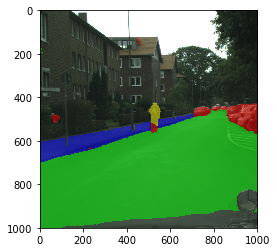

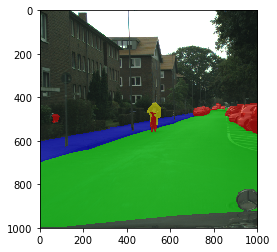

In [27]:
print("Accuracy =", acc)

visualize_prediction(test_img, soft)
visualize_prediction(test_img, test_gt)

# Evaluate Model

In [28]:
tf.reset_default_graph()

In [29]:
my_fcn = FCN_VGG()

In [30]:
batch_generator = get_data(mode='val', im_size=1000)

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


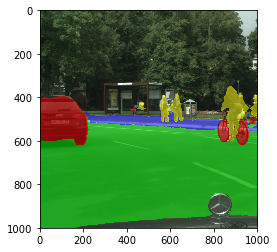

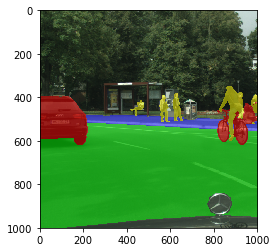

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


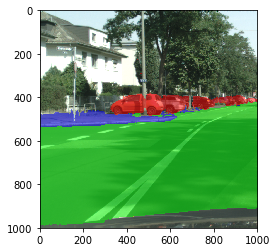

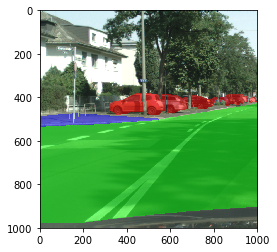

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


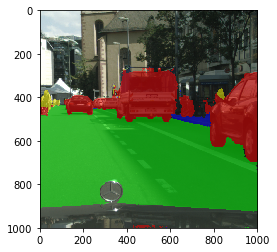

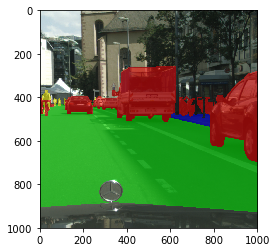

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


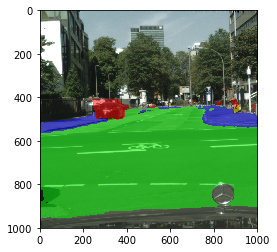

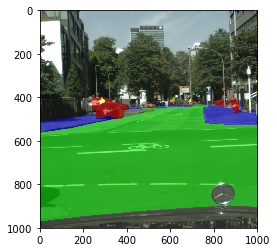

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


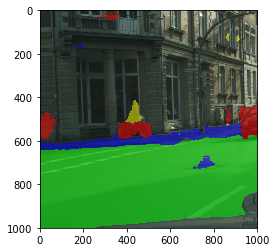

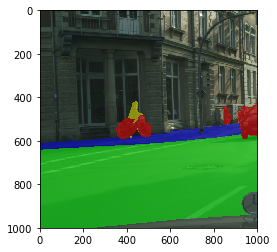

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


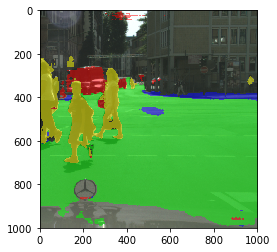

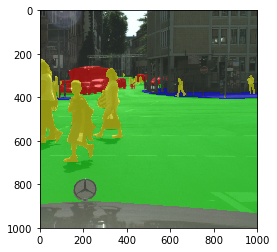

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


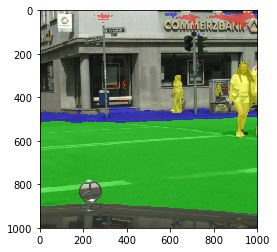

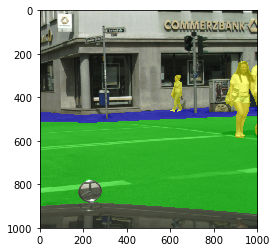

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


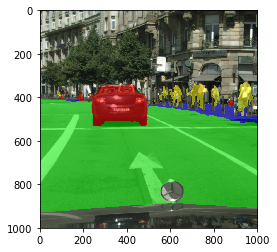

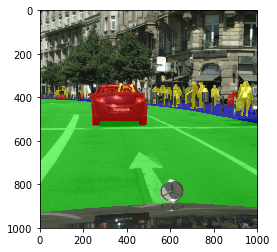

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


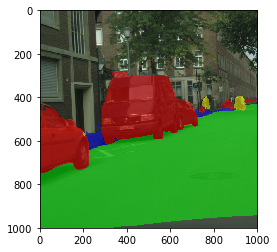

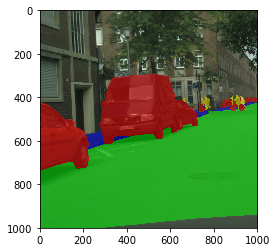

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


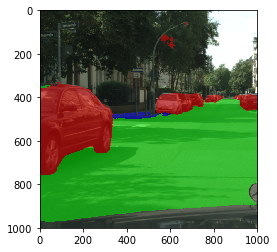

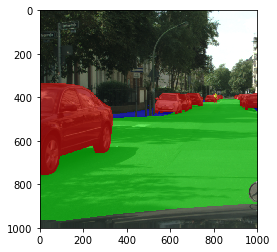

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


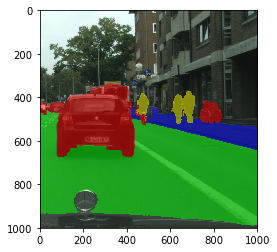

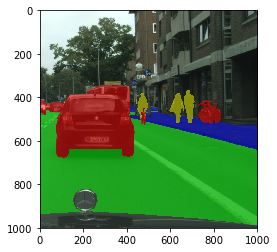

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


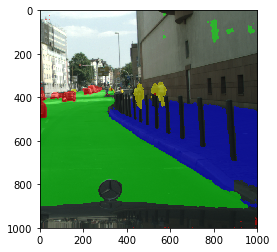

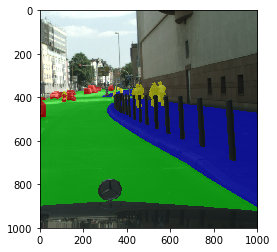

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


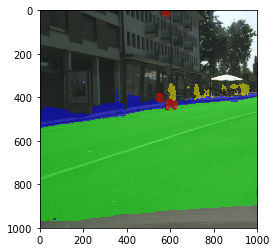

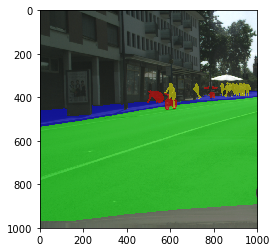

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


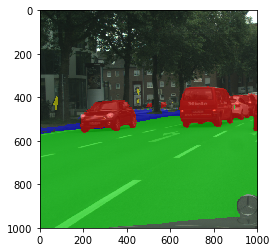

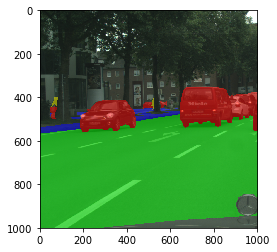

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


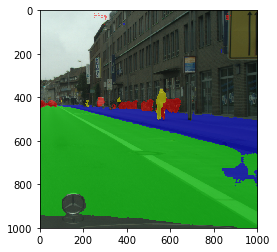

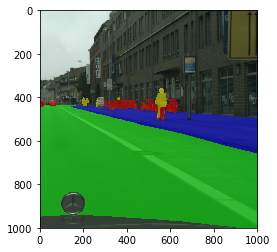

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


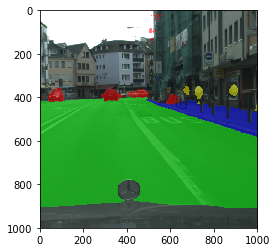

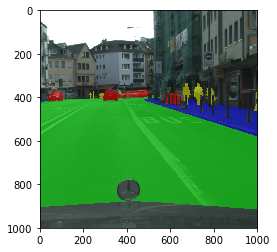

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


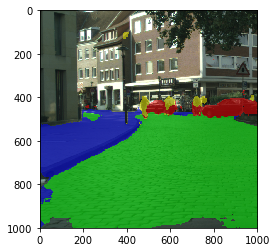

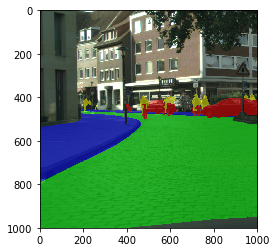

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


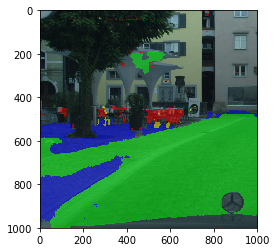

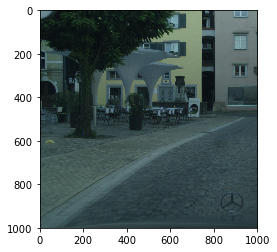

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


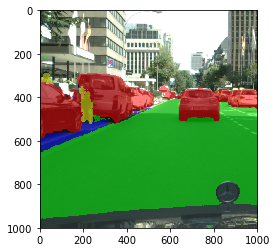

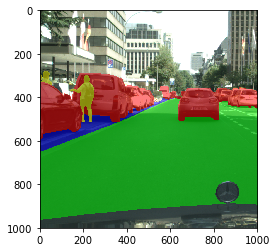

INFO:tensorflow:Restoring parameters from model/fcn_vgg_city2.ckpt


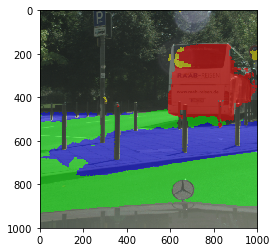

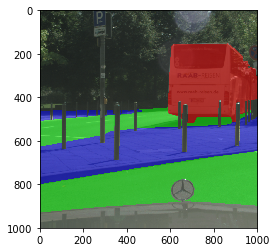

###############################
Average validation set accuracy = 0.947448715568
###############################


In [31]:
total_acc = 0.0
val_size = 20

for i in range(val_size):
    val_img, val_gt = next(batch_generator)
    results, acc = my_fcn.predict(model_path, val_img, gt=val_gt, restore=True)
    total_acc += acc

    visualize_prediction(val_img, results)
    visualize_prediction(val_img, val_gt)

total_acc /= val_size
print("###############################")
print("Average validation set accuracy =", total_acc)
print("###############################")

# Freeze model

In [32]:
tf.reset_default_graph()

In [33]:
from tensorflow.python.framework.graph_util import convert_variables_to_constants
from tensorflow.python.tools import inspect_checkpoint

In [34]:
output_path = "./model/"
checkpoint_path = tf.train.latest_checkpoint(output_path)
frozen_name = "frozen_FCN2.pb"

In [35]:
saver = tf.train.import_meta_graph(checkpoint_path + '.meta', import_scope=None)

output_node_names = "output"

with tf.Session() as sess:
    
    # Restore the variable values
    saver.restore(sess, checkpoint_path)
    # Get the graph def from our current graph
    graph_def = tf.get_default_graph().as_graph_def()
    # Turn all variables into constants
    frozen_graph_def = convert_variables_to_constants(sess, graph_def, output_node_names.split(","))
    
    # Save our new graph def
    with tf.gfile.GFile(output_path + frozen_name, "wb") as f:
        f.write(frozen_graph_def.SerializeToString())

INFO:tensorflow:Restoring parameters from ./model/fcn_vgg_city2.ckpt
INFO:tensorflow:Froze 76 variables.
Converted 76 variables to const ops.


# Use frozen model

In [10]:
def load_graph(my_path):
    # Load the pb file and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(my_path, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    
    # Now import the graph_def to our default graph.
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(
            graph_def,
            input_map=None,
            return_elements=None,
            # If you put name=None here instead of ''
            # it will relabel all your ops as "import/original_name"
            name='',
            op_dict=None, 
            producer_op_list=None
        )
    # Return the loaded graph
    return graph

In [32]:
tf.reset_default_graph()

In [33]:
graph = load_graph('./model/frozen_FCN.pb')

In [34]:
x = graph.get_tensor_by_name('x:0')
output = graph.get_tensor_by_name('output:0')

In [35]:
with tf.Session(graph=graph) as sess:

    %time out = sess.run(output, feed_dict={x: test_img})

CPU times: user 292 ms, sys: 88 ms, total: 380 ms
Wall time: 895 ms


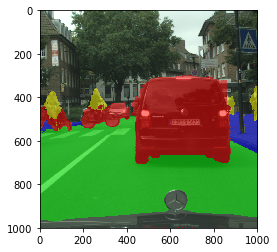

In [36]:
visualize_prediction(test_img, out)

In [223]:
# Optimize_for_inference deletes identity nodes (even if they are the output)
# so I'm searching for the name of the node before the identity I added as that
# will be the actual output
graph_def = graph.as_graph_def()
for i,node in enumerate(graph_def.node[-10:]):
    print(node)
    print(i)

name: "strided_slice_12/stack_1"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_INT32
      tensor_shape {
        dim {
          size: 1
        }
      }
      int_val: 4
    }
  }
}

0
name: "strided_slice_12/stack_2"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_INT32
      tensor_shape {
        dim {
          size: 1
        }
      }
      int_val: 1
    }
  }
}

1
name: "strided_slice_12"
op: "StridedSlice"
input: "Shape_6"
input: "strided_slice_12/stack"
input: "strided_slice_12/stack_1"
input: "strided_slice_12/stack_2"
attr {
  key: "Index"
  value {
    type: DT_INT32
  }
}
attr {
  key: "T"
  value {
    type: DT_INT32
  }
}
attr {
  key: "begin_mask"
  value {
    i: 0
  }
}
attr {
  key: "ellipsis_mask"
  value {
    i: 0
  }
}
attr {
  key: "end_mask"
  value {
    i: 0
  }
}
attr {
  key: "new_axis_mask

It seems that node is called "div"

# Optimize model

In [36]:
tf.reset_default_graph()

In [37]:
from tensorflow.python.tools import optimize_for_inference_lib

In [38]:
graph_def_path = './model/frozen_FCN2.pb'
optimized_model = './model/optimized_FCN2.pb'

In [39]:
# Load the graph we just froze
input_graph_def = tf.GraphDef()
with tf.gfile.Open(graph_def_path, "rb") as f:
    data = f.read()
    input_graph_def.ParseFromString(data)

output_graph_def = optimize_for_inference_lib.optimize_for_inference(
        input_graph_def,
        # A list of input nodes
        ["x"],
        # A list of output nodes
        ["div"],
        tf.float32.as_datatype_enum)

# Save the optimized graph
f = tf.gfile.FastGFile(optimized_model, "wb")
f.write(output_graph_def.SerializeToString())
f.close()

# Use optimized model for prediction

In [43]:
tf.reset_default_graph()

In [9]:
graph = load_graph(optimized_model)

In [42]:
x = graph.get_tensor_by_name('x:0')
output = graph.get_tensor_by_name('div:0')

In [43]:
with tf.Session(graph=graph) as sess:
    %time output = sess.run(output, feed_dict={x: test_img})

CPU times: user 316 ms, sys: 60 ms, total: 376 ms
Wall time: 877 ms


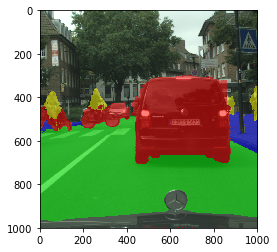

In [44]:
visualize_prediction(test_img, out)

# Test on video frame

In [44]:
tf.reset_default_graph()

In [45]:
optimized_model = './model/optimized_FCN2.pb'
graph = load_graph(optimized_model)

In [46]:
x = graph.get_tensor_by_name('x:0')
output = graph.get_tensor_by_name('div:0')

In [47]:
frame_path = 'video/demoVideo/stuttgart_01/stuttgart_01_000000_004581_leftImg8bit.png'

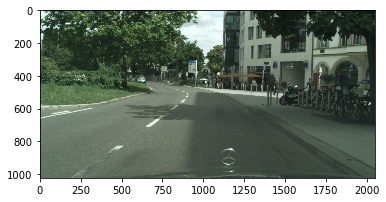

In [48]:
plot_image(image_path=frame_path)

In [49]:
img = misc.imread(frame_path).astype(np.float32)
img_arr = np.empty((1,img.shape[0],img.shape[1],img.shape[2]))
img_arr[0,:,:,:] = img

In [52]:
with tf.Session(graph=graph) as sess:
    %time result = sess.run(output, feed_dict={x: img_arr})

CPU times: user 344 ms, sys: 88 ms, total: 432 ms
Wall time: 1.47 s


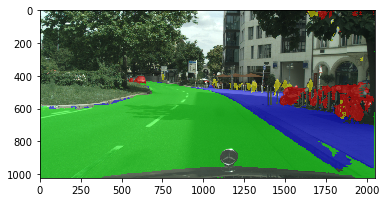

In [53]:
visualize_prediction(img_arr, result)

# Process video frame by frame

In [11]:
optimized_model = './model/optimized_FCN2.pb'

folder_path = 'video/demoVideo'
videos = ['stuttgart_00', 'stuttgart_01', 'stuttgart_02']
new_folders = ['demo_0', 'demo_1', 'demo_2']

vid0_files = []
vid0_files += glob.glob(os.path.join(os.path.join(folder_path, videos[0]), "*.png"))
vid1_files = []
vid1_files += glob.glob(os.path.join(os.path.join(folder_path, videos[1]), "*.png"))
vid2_files = []
vid2_files += glob.glob(os.path.join(os.path.join(folder_path, videos[2]), "*.png"))

In [12]:
def prep_frame(filename):
    img = misc.imread(filename).astype(np.float32)
    img_arr = np.empty((1,img.shape[0],img.shape[1],img.shape[2]))
    img_arr[0,:,:,:] = img
    return img_arr

In [13]:
tf.reset_default_graph()

In [14]:
graph = load_graph(optimized_model)

In [15]:
x = graph.get_tensor_by_name('x:0')
output = graph.get_tensor_by_name('div:0')

In [16]:
sess = tf.Session(graph=graph)

In [17]:
def process_frame(frame):
        
    # run network on frame here
    result = sess.run(output, feed_dict={x: frame})
    
    frame = np.squeeze(frame).astype(np.uint8)
    new_image = np.copy(frame)
    result = np.squeeze(result)
    mask = np.argmax(result, axis=2)
    # road = green
    new_image[mask[:,:]==0, :] = [0,255,0]
    # sidewalk = blue
    new_image[mask[:,:]==1, :] = [0,0,255]
    # pedestrians = yellow
    new_image[mask[:,:]==2, :] = [255,255,0]
    # vehicles = red
    new_image[mask[:,:]==3, :] = [255,0,0]
    # else is left the same
        
    new_image = Image.blend(Image.fromarray(np.squeeze(frame), mode='RGB').convert('RGBA'),
                            Image.fromarray(new_image, mode='RGB').convert('RGBA'),
                            alpha=0.5)
    
    new_image = np.array(new_image).astype(np.uint8)
    
    return new_image

In [18]:
def convert_video(in_folder, out_folder):
    
    vid_files = []
    in_path = os.path.join(folder_path, in_folder)
    vid_files += glob.glob(os.path.join(in_path, "*.png"))
    vid_files = sorted(vid_files)
    out_path = os.path.join(folder_path, out_folder)
    
    for frame in tqdm(vid_files):
        
        new_arr = process_frame(prep_frame(frame))
        new_im = Image.fromarray(new_arr)
        name = os.path.split(frame)[-1]
        path = os.path.join(out_path, name)
        new_im.save(path)
    

In [62]:
# convert_video(videos[0], new_folders[0])

100%|██████████| 599/599 [29:23<00:00,  2.90s/it]


In [28]:
convert_video(videos[1], new_folders[1])

100%|██████████| 1100/1100 [54:29<00:00,  3.01s/it]


In [26]:
convert_video(videos[2], new_folders[2])

100%|██████████| 1200/1200 [58:58<00:00,  2.97s/it]


In [66]:
sess.close()

In [23]:
test_path = 'video/demoVideo/stuttgart_01/stuttgart_01_000000_004306_leftImg8bit.png'
dest_path = 'video/demoVideo/demo_1/stuttgart_01_000000_004306_leftImg8bit.png'

In [24]:
img = process_frame(prep_frame(test_path))

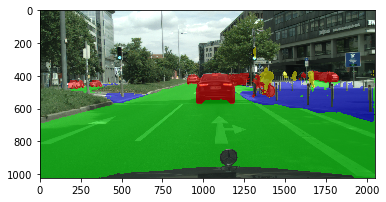

In [25]:
plot_image(dest_path)

This is the ffmpeg command to turn all the frames into a video (assumes you've already navigated to the correct folder):

ffmpeg -pattern_type glob -i '*.png' -r 30 -c:v libx264 -pix_fmt yuv420p demo_0.mp4